In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import sys
from torch.utils.data import DataLoader
sys.path.append('/home/mei/nas/docker/thesis')
from model.lstm_gnn_embedding_nograph import PatientOutcomeModelEmbedding
from dataloader.ts_reader import MultiModalDataset, collate_fn
from captum.attr import IntegratedGradients
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()

In [6]:

val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

# === LSTM + Flat Dataset ===
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_val = DataLoader(lstm_dataset_val , batch_size=32, shuffle=False, collate_fn=collate_fn)
lstm_loader_test = DataLoader(lstm_dataset_test , batch_size=32, shuffle=False, collate_fn=collate_fn)


In [7]:
flat_data= pd.read_hdf(test_data_dir+'/flat.h5')
ts_data= pd.read_hdf(test_data_dir+'/timeseries.h5')
feature_flat = list(flat_data.columns)
feature_ts = list(ts_data.columns)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
feature_ts = feature_ts[1:] # remove 'time' column

In [8]:
flat_input_dim = 104
ts_input_dim = 162
hidden_dim = 128

best_model = '/home/mei/nas/docker/thesis/data/model_results_noGraph/best_model_noGraph.pth'
model = PatientOutcomeModelEmbedding(flat_input_dim, ts_input_dim, hidden_dim).to(device)
model.load_state_dict(torch.load(best_model,weights_only=True))
model.eval()

PatientOutcomeModelEmbedding(
  (flat_encoder): Linear(in_features=104, out_features=128, bias=True)
  (ts_encoder): TimeSeriesEncoder(
    (lstm): LSTM(162, 128, batch_first=True, bidirectional=True)
  )
  (risk_predictor): RiskPredictor(
    (fc1): Linear(in_features=384, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

for patient_ids, ts_data, flat_data, risk_data, lengths in lstm_loader_val:
    fixed_patient_ids = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)
    fixed_ts = ts_data.to(device)
    fixed_flat = flat_data.to(device) 
    fixed_lengths = lengths.to(device)
    
    print("fixed_patient_ids", fixed_patient_ids)
    print("shape of fixed_ts", fixed_ts.shape)
    print("shape of fixed_flat", fixed_flat.shape)
    print("shape of fixed_lengths", fixed_lengths.shape)

    break

fixed_patient_ids tensor([1324132, 1319458, 1315032, 1326002, 1047426, 1327553, 1319866, 1316083,
        1001038, 1314486, 1321876, 1316657, 1315037, 1327459, 1031542, 1325080,
        1327324, 1028076, 1328874, 1328351, 1324044, 1026438, 1328128, 1009156,
        1316213, 1320121, 1332998, 1318178, 1328260, 1330668, 1327852, 1315925],
       device='cuda:0')
shape of fixed_ts torch.Size([32, 4021, 162])
shape of fixed_flat torch.Size([32, 104])
shape of fixed_lengths torch.Size([32])


In [10]:
def forward_flat(flat_input):
    """
    flat_input: tensor, shape (N, D_flat)
    other inputs are fixed: ts_sample, fixed_ts, fixed_lengths
    return risk scores
 
    """
    risk_scores, _ = model(flat_input, fixed_ts, fixed_lengths)
    return risk_scores
def forward_ts(ts_input):
    """
    ts_input: tensor, shape (N, T, D_ts)
    fixed_flat,  fixed_lengths
    return risk scores
    """
    risk_scores, _ = model(fixed_flat, ts_input, fixed_lengths)
    return risk_scores


In [11]:
baseline_flat = torch.zeros_like(fixed_flat)
baseline_ts = torch.zeros_like(fixed_ts)

ig_flat = IntegratedGradients(forward_flat)
ig_ts   = IntegratedGradients(forward_ts)

In [38]:
attr_flat, delta_flat = ig_flat.attribute(inputs=fixed_flat, baselines=baseline_flat, target=-1,
                                            return_convergence_delta=True,n_steps=1)
print("shape of attr_flat", attr_flat.shape)
print("shape of delta_flat", delta_flat.shape)

shape of attr_flat torch.Size([32, 104])
shape of delta_flat torch.Size([32])


In [41]:
was_training = model.training
model.train() 

attr_ts, delta_ts = ig_ts.attribute(inputs=fixed_ts,
    baselines=baseline_ts,
    target=-1,
    n_steps=50,
    internal_batch_size=32,  
    return_convergence_delta=True)

if not was_training:
    model.eval()

print("shape of attr_ts", attr_ts.shape)
print("shape of delta_ts", delta_ts.shape)

shape of attr_ts torch.Size([32, 4021, 162])
shape of delta_ts torch.Size([32])


In [ ]:
def plot_top_k_features(attr_flat: torch.Tensor, 
                        feature_names: list, 
                        k: int = 25, 
                        abs_importance: bool = True):
    """
    attr_flat: shape = (batch_size, D_flat)
    feature_names: name list of flat features
    k: top k features to show
    abs_importance: if True, use abs value to select top k
    
    """

    if attr_flat.ndim == 2:
        # => (D_flat,)
        attr_mean = attr_flat.mean(dim=0).detach().cpu().numpy()
    else:
        attr_mean = attr_flat.detach().cpu().numpy()

    if abs_importance:
        importance = np.abs(attr_mean)
    else:
        importance = attr_mean

    indices = np.argsort(-importance)
    top_indices = indices[:k]

    top_feature_names = [feature_names[i] for i in top_indices]
    top_values = attr_mean[top_indices]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(top_values)), top_values, color='skyblue')
    plt.yticks(range(len(top_values)), top_feature_names)
    plt.gca().invert_yaxis()  
    plt.xlabel("Integrated Gradients Attribution")
    plt.title(f"Top {k}  Features by IG")
    plt.show()

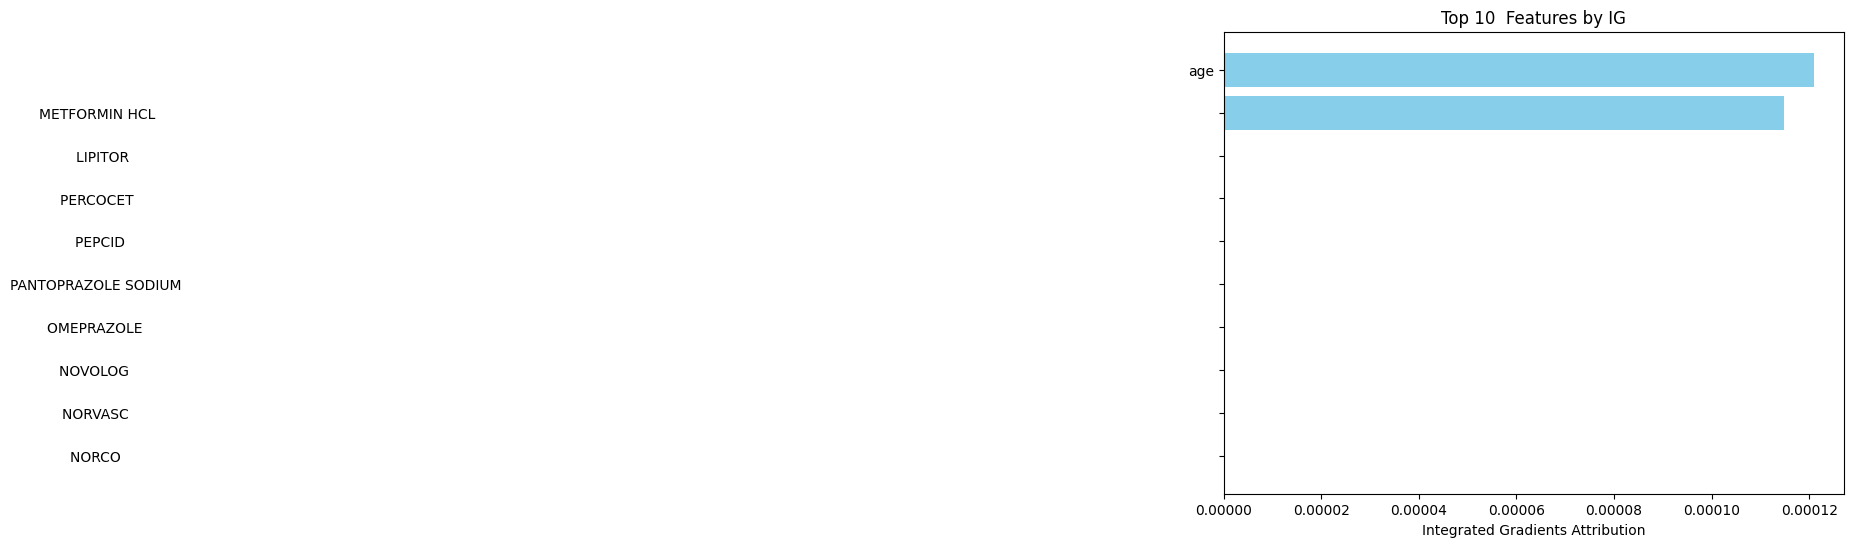

In [34]:
attr_flat_mean = attr_flat.mean(dim=0)
plot_top_k_features(attr_flat, feature_flat, k=10, abs_importance=False)

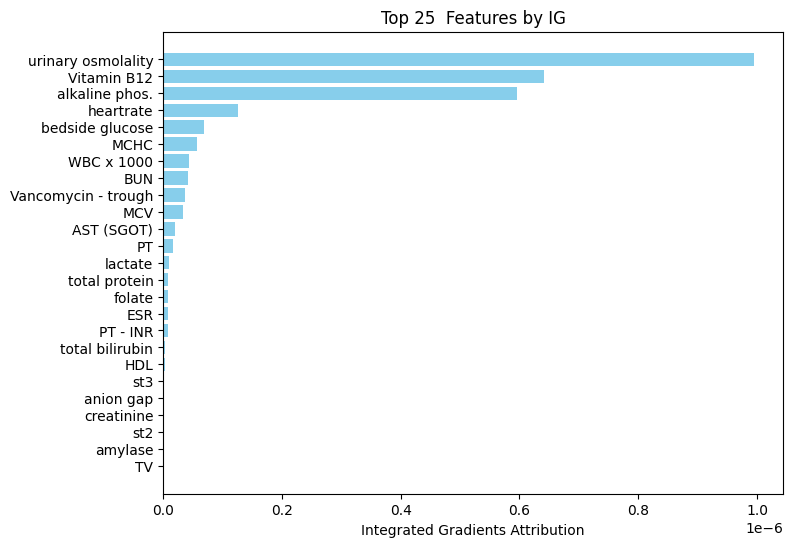

In [24]:
attr_ts_mean = attr_ts.mean(dim=0)
plot_top_k_features(attr_ts_mean,feature_ts, k=25, abs_importance=False)

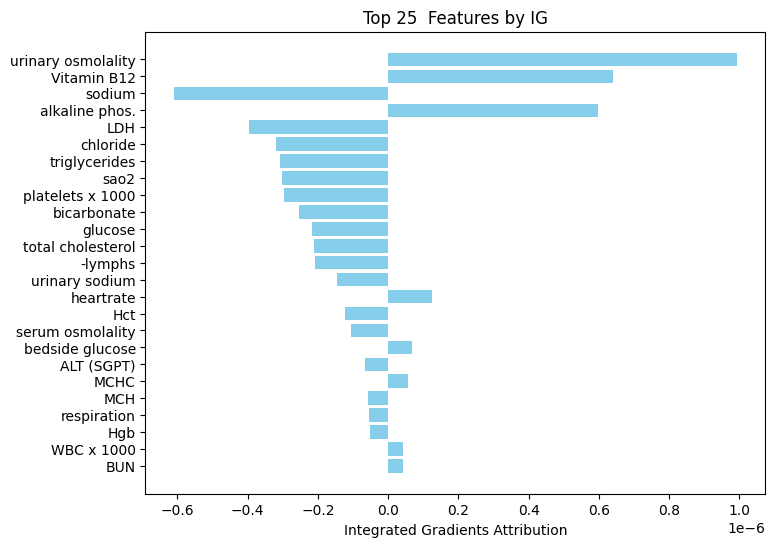

In [26]:
attr_ts_mean = attr_ts.mean(dim=0)
plot_top_k_features(attr_ts_mean,feature_ts, k=25, abs_importance=True)